# Building Prophet Models for YNP Geysers

After the pre-processing step, the next step is building models. Since the geyser eruption data is intuitively time-series, the use of Prophet, a general purpose forecasting tool open-sourced by Facebook, is ideal.

Additionally Prophet, inherently, is able to deal with missing data, noisy data and irregularly spaced data, all three properties that are present in my dataset.

In [1]:
# setup

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

import math

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from datetime import datetime
from pytz import timezone

from fbprophet import Prophet

import pickle

### Importing Data

In [3]:
maindf = pd.read_csv('processed_dataframe.csv')
maindf

datetime          geyser  eruption_time_epoch  \
0       2000-01-01 05:12:00-07:00  Great Fountain            946728720   
1       2000-01-01 05:59:00-07:00           Grand            946731540   
2       2000-01-01 16:37:00-07:00  Great Fountain            946769820   
3       2000-01-01 17:14:00-07:00           Grand            946772040   
4       2000-01-02 04:18:00-07:00  Great Fountain            946811880   
...                           ...             ...                  ...   
786424  2019-09-05 20:40:00-06:00             Jet           1567737600   
786425  2019-09-05 20:41:00-06:00             Jet           1567737660   
786426  2019-09-05 20:43:00-06:00             Jet           1567737780   
786427  2019-09-05 21:01:00-06:00           Aurum           1567738860   
786428  2019-09-05 21:27:00-06:00    Old Faithful           1567740420   

              date      time  interval_length  
0       2000-01-01  05:12:00              NaN  
1       2000-01-01  05:59:00              NaN  
2       2000-01-01  16:37:00            685.0  
3       2000-01-01  17:14:00            675.0  
4       2000-01-02  04:18:00            701.0  
...            ...       ...              ...  
786424  2019-09-05  20:40:00              2.0  
786425  2019-09-05  20:41:00              1.0  
786426  2019-09-05  20:43:00              2.0  
786427  2019-09-05  21:01:00            373.0  
786428  2019-09-05  21:27:00             93.0  

[786429 rows x 6 columns]

In [4]:
# Keeping only data from 2010 onward

print(maindf.shape)
print(maindf.index[maindf['date'] == '2010-01-01'].to_list()[0])
maindf = maindf.loc[410111:]
print(maindf.shape)

(786429, 6)
410111
(376318, 6)


Old Faithful           50861
Daisy                  27918
Little Cub             24221
Lion                   21351
Plume                  19196
Oblong                 11613
Grand                  11224
Aurum                  10810
Jet                    10723
Spouter                10706
Bead                   10484
Riverside               9289
Fountain                9203
Turban                  9172
Vixen                   8228
Depression              7830
Castle                  6487
Great Fountain          5629
Sprinkler               5583
Grotto                  5156
Sawmill                 4728
Beehive                 4629
Whirligig               4368
Dome                    3986
Narcissus               3694
Logbridge               3462
Beehive's Indicator     3279
West Triplet            3262
Bulger                  3078
Artemisia               3047
Name: geyser, dtype: int64


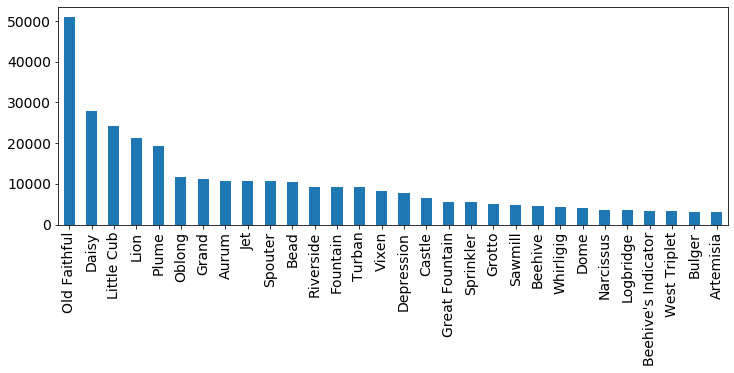

In [8]:
# Checking data size for top 30 geysers 

print(maindf['geyser'].value_counts()[:30])
maindf['geyser'].value_counts()[:30].plot.bar(figsize=(12,4), fontsize=14)

#### Creating UTC time columns because of Prophet requirement

In [9]:
# Adding UTC datetime column to maindf
maindf['utc_datetime'] = pd.to_datetime(maindf['eruption_time_epoch'],unit='s')

/home/siddharth/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
# Resetting index to utc_datetime
maindf.set_index('utc_datetime', inplace=True)

### Transforming Data

Calculating a variable for time-untill-next-eruption. This way, for each (Geyser,Timestamp) pair, an additional value which indicates the time untill next eruption is calculated. This becomes the target variable that is then predicted by the model. 

In [11]:
# creating column for time till next eruption
maindf['t_nxt_eruption'] = np.nan

/home/siddharth/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
### populating t_nxt_eruption

# Creating an empty initial-timestamp dictionary  
geyser_ini_timestamp_dict = dict.fromkeys(maindf.geyser.unique(),0)

# Populating timstamp dictionary with initial timestamps
for i in maindf.index:
    geyser = maindf.get_value(i,'geyser')
    if geyser_ini_timestamp_dict[geyser] == 0:
        geyser_ini_timestamp_dict[geyser] = i

/home/siddharth/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



In [13]:
# populating t_nxt_eruption

for i in maindf.index:
    geyser = maindf.get_value(i,'geyser')
    prev_timestamp = geyser_ini_timestamp_dict[geyser] 
    if i == prev_timestamp:
        pass
    else:
        t_nxt_erupt = prev_timestamp - i
        t_nxt_erupt = (t_nxt_erupt.total_seconds() // 60) * -1
        maindf.set_value(prev_timestamp,'t_nxt_eruption', t_nxt_erupt)
        geyser_ini_timestamp_dict[geyser] = i

/home/siddharth/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

/home/siddharth/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



In [14]:
maindf.reset_index(inplace=True)

In [15]:
maindf

utc_datetime                   datetime        geyser  \
0      2010-01-01 07:03:00  2010-01-01 00:03:00-07:00    Depression   
1      2010-01-01 07:10:00  2010-01-01 00:10:00-07:00         Daisy   
2      2010-01-01 07:24:00  2010-01-01 00:24:00-07:00          Rift   
3      2010-01-01 07:30:00  2010-01-01 00:30:00-07:00         Plume   
4      2010-01-01 07:33:00  2010-01-01 00:33:00-07:00    Little Cub   
...                    ...                        ...           ...   
376313 2019-09-06 02:40:00  2019-09-05 20:40:00-06:00           Jet   
376314 2019-09-06 02:41:00  2019-09-05 20:41:00-06:00           Jet   
376315 2019-09-06 02:43:00  2019-09-05 20:43:00-06:00           Jet   
376316 2019-09-06 03:01:00  2019-09-05 21:01:00-06:00         Aurum   
376317 2019-09-06 03:27:00  2019-09-05 21:27:00-06:00  Old Faithful   

        eruption_time_epoch        date      time  interval_length  \
0                1262329380  2010-01-01  00:03:00            172.0   
1                1262329800  2010-01-01  00:10:00            176.0   
2                1262330640  2010-01-01  00:24:00           1506.0   
3                1262331000  2010-01-01  00:30:00             61.0   
4                1262331180  2010-01-01  00:33:00             55.0   
...                     ...         ...       ...              ...   
376313           1567737600  2019-09-05  20:40:00              2.0   
376314           1567737660  2019-09-05  20:41:00              1.0   
376315           1567737780  2019-09-05  20:43:00              2.0   
376316           1567738860  2019-09-05  21:01:00            373.0   
376317           1567740420  2019-09-05  21:27:00             93.0   

        t_nxt_eruption  
0                151.0  
1                170.0  
2               1208.0  
3                 65.0  
4                 56.0  
...                ...  
376313             1.0  
376314             2.0  
376315             NaN  
376316             NaN  
376317             NaN  

[376318 rows x 8 columns]

## Separating Geysers into individual dataframes and building model

### Old Faithful

In [16]:
ofdf = maindf.loc[maindf['geyser'] == 'Old Faithful']
ofdf.shape

(50861, 8)

t_nxt_eruption captures time between two events. If eruption events were not recorded between two events, then the value of t_nxt_eruption increases. As a result when we plot the frequency distribution of t_nxt eruption, we see a long tailed distribution representing timepoints after which there are missing events.

I filter out these data points by based on values which will only retain the primary distribution. See similar description for Riverside geyser

Text(0.5, 1.0, 'Histogram of Interval Lengths')

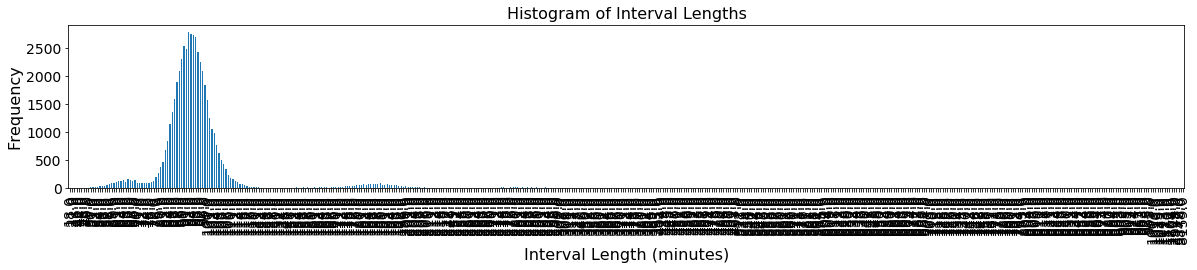

In [17]:
#print(ofdf['t_nxt_eruption'].value_counts().sort_index().iloc[10:80])
ax = ofdf['t_nxt_eruption'].value_counts().sort_index().iloc[:].plot.bar(figsize=(20,3), fontsize=14)
ax.set_xlabel("Interval Length (minutes)", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Histogram of Interval Lengths", fontsize=16)

Filtering the data such that it only contains t_nxt_eruption values between 51 and 120 minutes results in a much cleaner frequency distribution

51.0      6
52.0      6
53.0     10
54.0     25
55.0     37
         ..
116.0    42
117.0    29
118.0    20
119.0    19
120.0    11
Name: t_nxt_eruption, Length: 70, dtype: int64


Text(0.5, 1.0, 'Histogram of Interval Lengths')

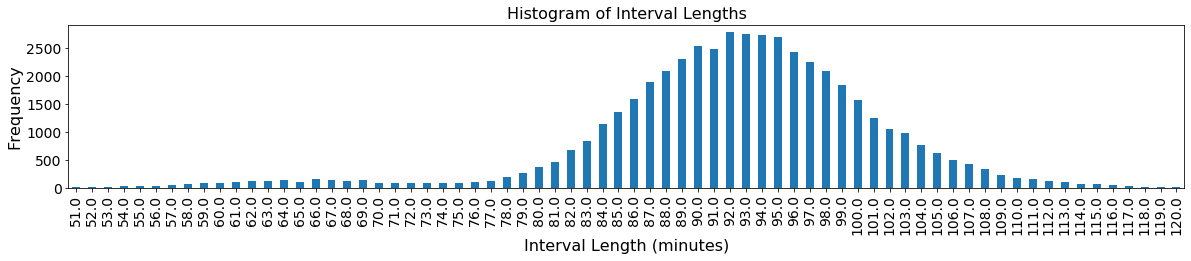

In [24]:
print(ofdf['t_nxt_eruption'].value_counts().sort_index().iloc[10:80])
ax = ofdf['t_nxt_eruption'].value_counts().sort_index().iloc[10:80].plot.bar(figsize=(20,3), fontsize=14)
ax.set_xlabel("Interval Length (minutes)", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Histogram of Interval Lengths", fontsize=16)

In [25]:
print(ofdf.shape)
ofdf = ofdf.loc[(ofdf['t_nxt_eruption'] >= 51.0) & (ofdf['t_nxt_eruption'] <= 120.0)]
print(ofdf.shape)
ofdf.head()

(50861, 8)
(48642, 8)


utc_datetime                   datetime        geyser  \
7  2010-01-01 08:10:00  2010-01-01 01:10:00-07:00  Old Faithful   
16 2010-01-01 09:52:00  2010-01-01 02:52:00-07:00  Old Faithful   
24 2010-01-01 11:26:00  2010-01-01 04:26:00-07:00  Old Faithful   
38 2010-01-01 12:58:00  2010-01-01 05:58:00-07:00  Old Faithful   
43 2010-01-01 14:34:00  2010-01-01 07:34:00-07:00  Old Faithful   

    eruption_time_epoch        date      time  interval_length  t_nxt_eruption  
7            1262333400  2010-01-01  01:10:00            161.0           102.0  
16           1262339520  2010-01-01  02:52:00            102.0            94.0  
24           1262345160  2010-01-01  04:26:00             94.0            92.0  
38           1262350680  2010-01-01  05:58:00             92.0            96.0  
43           1262356440  2010-01-01  07:34:00             96.0            97.0

In [27]:
# Keeping only data from 2015 onward because too many data points
print(ofdf.index[ofdf['date'] == '2017-01-01'].to_list()[0])
print(ofdf.shape)
ofdf = ofdf.loc[275513:]
ofdf.shape

275513
(48642, 8)


(13470, 8)

#### Raw Data

After the filtering procedure, the raw data still has a lot of noise in it. This can be because the fluctuations in t_nxt_eruption over a long span of time can be more than the noise introduced by inconsistent event recording and hence the filtering procedure will not be able to weed out the missing events captured in long interval lengths.

Performing a smoothing procedure transforms the data such that long t_nxt_eruption values are decreased but the shorter values reflecting no missing events remain overall unaffected.

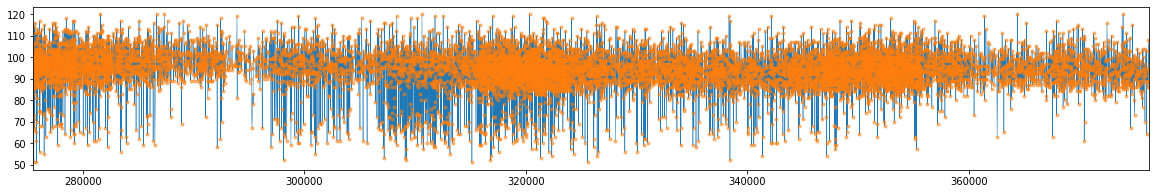

In [29]:
ofdf.iloc[:].t_nxt_eruption.plot(linewidth=0.5, figsize=(20, 3))
ofdf.iloc[:].t_nxt_eruption.plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3))
#ofdf.t_nxt_eruption.plot(linewidth=0.5, figsize=(20, 3))
#ofdf.t_nxt_eruption.plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3))

#### Smoothed Data

In [47]:
ofdf['smooth_interval'] = ofdf.t_nxt_eruption.rolling(5).mean()

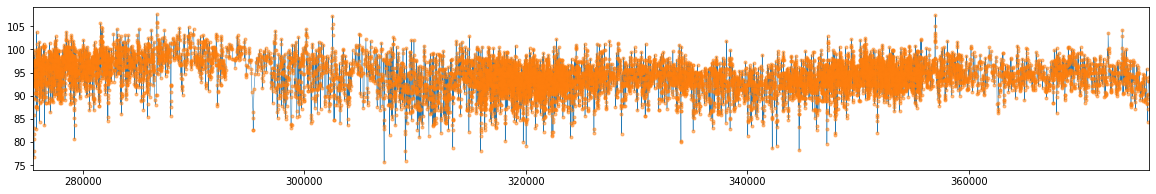

In [49]:
ofdf.iloc[:].smooth_interval.plot(linewidth=0.5, figsize=(20, 3))
ofdf.iloc[:].smooth_interval.plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3))

In [30]:
ofdf.head()

utc_datetime                   datetime        geyser  \
275513 2017-01-01 07:09:00  2017-01-01 00:09:00-07:00  Old Faithful   
275515 2017-01-01 08:53:00  2017-01-01 01:53:00-07:00  Old Faithful   
275517 2017-01-01 10:02:00  2017-01-01 03:02:00-07:00  Old Faithful   
275519 2017-01-01 11:40:00  2017-01-01 04:40:00-07:00  Old Faithful   
275520 2017-01-01 13:17:00  2017-01-01 06:17:00-07:00  Old Faithful   

        eruption_time_epoch        date      time  interval_length  \
275513           1483254540  2017-01-01  00:09:00             90.0   
275515           1483260780  2017-01-01  01:53:00            104.0   
275517           1483264920  2017-01-01  03:02:00             69.0   
275519           1483270800  2017-01-01  04:40:00             98.0   
275520           1483276620  2017-01-01  06:17:00             97.0   

        t_nxt_eruption  
275513           104.0  
275515            69.0  
275517            98.0  
275519            97.0  
275520           101.0

In [31]:
# Checking last day of May 31st 2019
print(ofdf.index[ofdf['date'] == '2019-05-31'].to_list()[:])

[360106, 360107, 360108, 360122, 360127, 360136, 360163, 360184, 360209, 360228, 360258, 360294, 360305, 360314, 360319]


In [58]:
# creating df for prophet

cols = ['utc_datetime','t_nxt_eruption']
df = ofdf.loc[:360319,cols]

valdf = ofdf.loc[360319:,cols]
valdf.drop(columns=['t_nxt_eruption'], axis=1, inplace=True)
valdf.rename(columns = {'utc_datetime':'ds'}, inplace=True)
print(valdf.head())

df.rename(columns = {'utc_datetime':'ds', 't_nxt_eruption':'y'}, inplace=True)

df = df.reset_index()
df.drop(['index'], axis=1, inplace=True)

df

                        ds
360319 2019-06-01 05:28:00
360321 2019-06-01 06:56:00
360323 2019-06-01 08:33:00
360325 2019-06-01 09:59:00
360329 2019-06-01 11:36:00


ds      y
0     2017-01-01 07:09:00  104.0
1     2017-01-01 08:53:00   69.0
2     2017-01-01 10:02:00   98.0
3     2017-01-01 11:40:00   97.0
4     2017-01-01 13:17:00  101.0
...                   ...    ...
12314 2019-05-31 23:13:00   94.0
12315 2019-06-01 00:47:00   92.0
12316 2019-06-01 02:19:00   93.0
12317 2019-06-01 03:52:00   96.0
12318 2019-06-01 05:28:00   88.0

[12319 rows x 2 columns]

In [59]:
# Already created and fit the model
m_oldfaithful = Prophet(changepoint_prior_scale=0.25)

In [60]:
# Already created and fit the model
m_oldfaithful.fit(df)

In [42]:
# Opening preFit model 
#with open('m_oldfaithful_model.pckl', 'rb') as fin:
#    m_oldfaithful = pickle.load(fin)

In [61]:
l = len(valdf['ds'])
future = m_oldfaithful.make_future_dataframe(periods=l)
future = future.iloc[:(-1*l)]
future = pd.concat([future,valdf])

In [54]:
ofdf_forecast = m_oldfaithful.predict(future)

In [62]:
# This cell has been executed after m_oldfaithful model was refit to raw data. Hence the two different forecast dataframe.
# The actual model in use for making predictions is the model fit on smoothed data.
ofdf_forecast2 = m_oldfaithful.predict(future)

In [55]:
print(ofdf_forecast.shape)
ofdf_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

(13471, 22)


ds       yhat  yhat_lower  yhat_upper
13466 2019-09-05 16:11:00  91.879031   86.675404   97.017131
13467 2019-09-05 17:45:00  91.830285   86.467036   97.037612
13468 2019-09-05 19:14:00  91.804111   86.513507   96.810028
13469 2019-09-06 00:28:00  91.867675   86.667110   97.348075
13470 2019-09-06 01:54:00  91.836929   86.696692   96.954597

The difference between forecast 1 and 2 is that for forecast 1, the model is trained on raw data. For forecast 2 the model is trained on smoothed data. Because raw data has a higher spread of values, the model assigns higher uncertainty to each prediction. This larger time window then captures more events successfully giving a high percent accuracy to model trained on raw data. In reality the Mean Absolute Errors of both models are very similar and there is no real difference between the models.

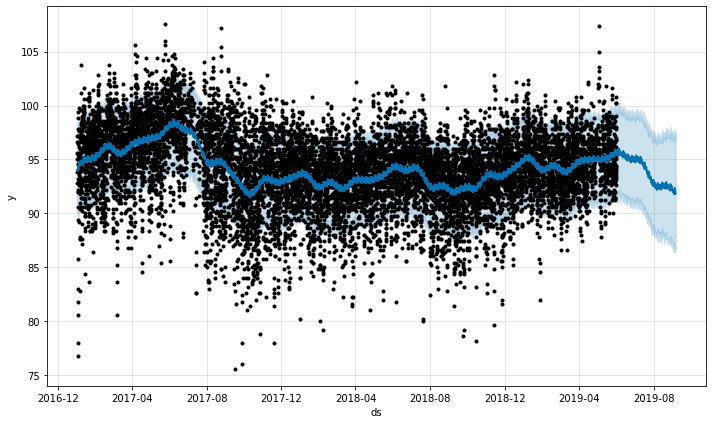

In [56]:
fig1 = m_oldfaithful.plot(ofdf_forecast)

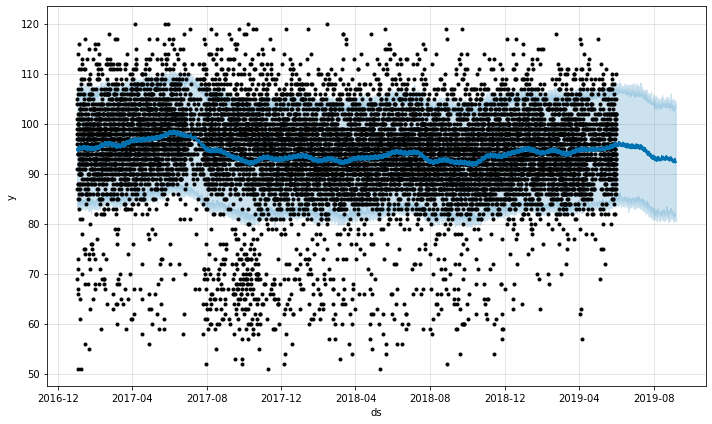

In [63]:
fig2 = m_oldfaithful.plot(ofdf_forecast2)

In [721]:
# Prefit model already saved
#with open('m_oldfaithful_model.pckl', 'wb') as fout:
#    pickle.dump(m_oldfaithful, fout)

In [47]:
#fig2 = m.plot_components(forecast)

In [68]:
testdf = ofdf.loc[360319:,['utc_datetime','t_nxt_eruption']]
testdf.reset_index(inplace=True)

l = len(valdf['ds'])

traindf = ofdf_forecast.iloc[(-1*l):]
traindf = traindf[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
traindf.reset_index(inplace=True)

newdf = pd.concat([traindf,testdf], axis=1)

newdf['abs_err'] = (newdf['yhat']-newdf['t_nxt_eruption']).abs()
print('Mean Absolute Error of Old Faithful predictions ', newdf['abs_err'].mean())

newdf['uncertainty'] = newdf['yhat_upper']-newdf['yhat_lower']
print('Mean Uncertainty in predictions ', newdf['uncertainty'].mean())
print(newdf['uncertainty'].std())

newdf['accr'] = 0

for i in newdf.index:
    if newdf.loc[i,'abs_err'] <= newdf.loc[i,'uncertainty']:
        newdf.loc[i,'accr'] = 1

acr = (newdf['accr'].value_counts()[1]/len(newdf.index)) * 100
print('Percent Accuracy of predictions ', acr)

newdf

Mean Absolute Error of Old Faithful predictions  5.470197758272956
Mean Uncertainty in predictions  8.620026193791615
0.7244791317454474
Percent Accuracy of predictions  80.38194444444444


index                  ds       yhat  yhat_lower  yhat_upper   index  \
0     12319 2019-06-01 05:28:00  95.773407   91.468946   99.604238  360319   
1     12320 2019-06-01 06:56:00  95.844649   91.599158   99.649853  360321   
2     12321 2019-06-01 08:33:00  95.874417   91.994269   99.804151  360323   
3     12322 2019-06-01 09:59:00  95.866885   91.730796  100.007058  360325   
4     12323 2019-06-01 11:36:00  95.838081   92.105106   99.906231  360329   
...     ...                 ...        ...         ...         ...     ...   
1147  13466 2019-09-05 16:11:00  91.879031   86.675404   97.017131  376173   
1148  13467 2019-09-05 17:45:00  91.830285   86.467036   97.037612  376187   
1149  13468 2019-09-05 19:14:00  91.804111   86.513507   96.810028  376224   
1150  13469 2019-09-06 00:28:00  91.867675   86.667110   97.348075  376290   
1151  13470 2019-09-06 01:54:00  91.836929   86.696692   96.954597  376303   

            utc_datetime  t_nxt_eruption    abs_err  uncertainty  accr  
0    2019-06-01 05:28:00            88.0   7.773407     8.135292     1  
1    2019-06-01 06:56:00            97.0   1.155351     8.050695     1  
2    2019-06-01 08:33:00            86.0   9.874417     7.809882     0  
3    2019-06-01 09:59:00            97.0   1.133115     8.276262     1  
4    2019-06-01 11:36:00            86.0   9.838081     7.801125     0  
...                  ...             ...        ...          ...   ...  
1147 2019-09-05 16:11:00            94.0   2.120969    10.341727     1  
1148 2019-09-05 17:45:00            89.0   2.830285    10.570575     1  
1149 2019-09-05 19:14:00           108.0  16.195889    10.296521     0  
1150 2019-09-06 00:28:00            86.0   5.867675    10.680964     1  
1151 2019-09-06 01:54:00            93.0   1.163071    10.257904     1  

[1152 rows x 11 columns]

In [64]:
testdf = ofdf.loc[360319:,['utc_datetime','t_nxt_eruption']]
testdf.reset_index(inplace=True)

l = len(valdf['ds'])

traindf = ofdf_forecast2.iloc[(-1*l):]
traindf = traindf[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
traindf.reset_index(inplace=True)

newdf = pd.concat([traindf,testdf], axis=1)

newdf['abs_err'] = (newdf['yhat']-newdf['t_nxt_eruption']).abs()
print('Mean Absolute Error of Old Faithful predictions ', newdf['abs_err'].mean())

newdf['uncertainty'] = newdf['yhat_upper']-newdf['yhat_lower']
print('Mean Uncertainty in predictions ', newdf['uncertainty'].mean())

newdf['accr'] = 0

for i in newdf.index:
    if newdf.loc[i,'abs_err'] <= newdf.loc[i,'uncertainty']:
        newdf.loc[i,'accr'] = 1

acr = (newdf['accr'].value_counts()[1]/len(newdf.index)) * 100
print('Percent Accuracy of predictions ', acr)

newdf

Mean Absolute Error of Old Faithful predictions  5.463592905324482
Mean Uncertainty in predictions  22.50301422048521
Percent Accuracy of predictions  98.95833333333334


index                  ds       yhat  yhat_lower  yhat_upper   index  \
0     12319 2019-06-01 05:28:00  96.191055   85.343006  107.823950  360319   
1     12320 2019-06-01 06:56:00  96.177074   85.256075  107.729344  360321   
2     12321 2019-06-01 08:33:00  95.949539   84.284432  107.236746  360323   
3     12322 2019-06-01 09:59:00  95.750029   84.794466  106.848451  360325   
4     12323 2019-06-01 11:36:00  95.752635   84.799627  106.606529  360329   
...     ...                 ...        ...         ...         ...     ...   
1147  13466 2019-09-05 16:11:00  92.218594   81.316070  103.597858  376173   
1148  13467 2019-09-05 17:45:00  92.287647   80.667750  103.799251  376187   
1149  13468 2019-09-05 19:14:00  92.496805   81.328357  103.695250  376224   
1150  13469 2019-09-06 00:28:00  92.204419   81.762791  103.530905  376290   
1151  13470 2019-09-06 01:54:00  92.332817   80.447190  102.957014  376303   

            utc_datetime  t_nxt_eruption    abs_err  uncertainty  accr  
0    2019-06-01 05:28:00            88.0   8.191055    22.480944     1  
1    2019-06-01 06:56:00            97.0   0.822926    22.473269     1  
2    2019-06-01 08:33:00            86.0   9.949539    22.952314     1  
3    2019-06-01 09:59:00            97.0   1.249971    22.053985     1  
4    2019-06-01 11:36:00            86.0   9.752635    21.806902     1  
...                  ...             ...        ...          ...   ...  
1147 2019-09-05 16:11:00            94.0   1.781406    22.281789     1  
1148 2019-09-05 17:45:00            89.0   3.287647    23.131501     1  
1149 2019-09-05 19:14:00           108.0  15.503195    22.366892     1  
1150 2019-09-06 00:28:00            86.0   6.204419    21.768114     1  
1151 2019-09-06 01:54:00            93.0   0.667183    22.509825     1  

[1152 rows x 11 columns]

### Beehive

In [79]:
beedf = maindf.loc[maindf['geyser'] == 'Beehive']
beedf.shape

(4629, 8)

441.0     1
456.0     1
488.0     1
517.0     1
523.0     1
         ..
1687.0    1
1689.0    1
1690.0    1
1692.0    1
1694.0    1
Name: t_nxt_eruption, Length: 1000, dtype: int64


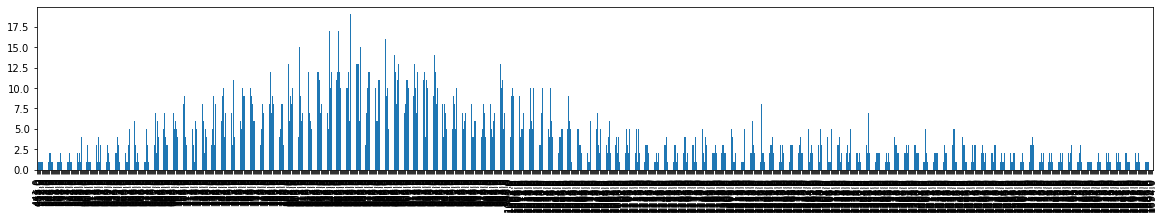

In [80]:
print(beedf['t_nxt_eruption'].value_counts().sort_index().iloc[:1000])
beedf['t_nxt_eruption'].value_counts().sort_index().iloc[:1000].plot.bar(figsize=(20,3))

In [81]:
print(beedf.shape)
beedf = beedf.loc[(beedf['t_nxt_eruption'] <= 1500.0)]
print(beedf.shape)
beedf.tail()

(4629, 8)
(4086, 8)


utc_datetime                   datetime   geyser  \
375583 2019-09-01 22:40:00  2019-09-01 16:40:00-06:00  Beehive   
375688 2019-09-02 17:39:00  2019-09-02 11:39:00-06:00  Beehive   
375760 2019-09-03 12:24:00  2019-09-03 06:24:00-06:00  Beehive   
375911 2019-09-04 03:45:00  2019-09-03 21:45:00-06:00  Beehive   
376014 2019-09-04 19:18:00  2019-09-04 13:18:00-06:00  Beehive   

        eruption_time_epoch        date      time  interval_length  \
375583           1567377600  2019-09-01  16:40:00           2102.0   
375688           1567445940  2019-09-02  11:39:00           1139.0   
375760           1567513440  2019-09-03  06:24:00           1125.0   
375911           1567568700  2019-09-03  21:45:00            921.0   
376014           1567624680  2019-09-04  13:18:00            933.0   

        t_nxt_eruption  
375583          1139.0  
375688          1125.0  
375760           921.0  
375911           933.0  
376014          1269.0

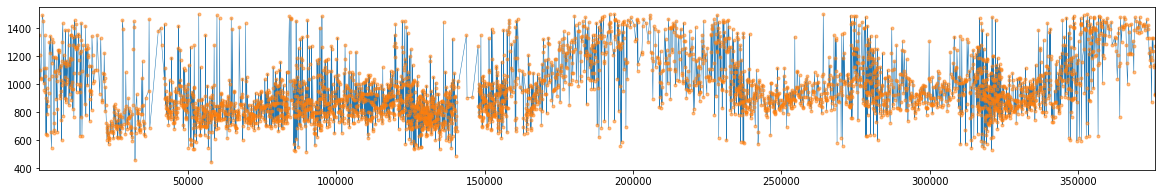

In [82]:
beedf.t_nxt_eruption.plot(linewidth=0.5, figsize=(20, 3))
beedf.t_nxt_eruption.plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3))

In [83]:
beedf['smooth_interval'] = beedf.t_nxt_eruption.rolling(5).mean()

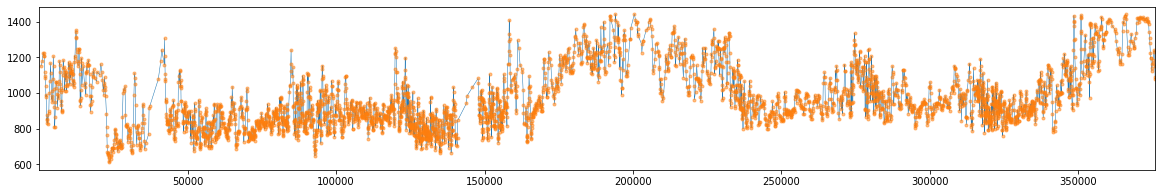

In [84]:
beedf.smooth_interval.plot(linewidth=0.5, figsize=(20, 3))
beedf.smooth_interval.plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3))

In [85]:
# Checking last day of May 31st 2019
print(beedf.index[beedf['date'] == '2019-05-31'].to_list())

[360186]


In [86]:
# creating df for prophet

cols = ['utc_datetime','smooth_interval']
bdf = beedf.loc[:360186,cols]

valdf = beedf.loc[360186:,cols]
valdf.drop(columns=['smooth_interval'], axis=1, inplace=True)
valdf.rename(columns = {'utc_datetime':'ds'}, inplace=True)
print(valdf.head())

bdf.rename(columns = {'utc_datetime':'ds', 'smooth_interval':'y'}, inplace=True)

bdf = bdf.reset_index()
bdf.drop(['index'], axis=1, inplace=True)

bdf

                        ds
360186 2019-05-31 18:14:00
360398 2019-06-01 17:56:00
360617 2019-06-02 16:17:00
361165 2019-06-04 16:54:00
361420 2019-06-05 16:58:00


ds       y
0    2010-01-01 20:15:00     NaN
1    2010-01-02 18:47:00     NaN
2    2010-01-03 14:56:00     NaN
3    2010-01-04 09:17:00     NaN
4    2010-01-05 02:42:00  1149.4
...                  ...     ...
4006 2019-05-26 18:55:00  1344.8
4007 2019-05-28 18:14:00  1342.2
4008 2019-05-29 18:18:00  1399.2
4009 2019-05-30 18:51:00  1391.0
4010 2019-05-31 18:14:00  1405.8

[4011 rows x 2 columns]

In [87]:
# Already created and fit the model
#m_beehive = Prophet(changepoint_prior_scale=0.25)

In [88]:
# Already created and fit the model
#m_beehive.fit(bdf)

In [89]:
# Opening preFit model 
with open('m_beehive_model.pckl', 'rb') as fin:
    m_beehive = pickle.load(fin)

In [90]:
l = len(valdf['ds'])
future = m_beehive.make_future_dataframe(periods=l)
future = future.iloc[:(-1*l)]
future = pd.concat([future,valdf])

In [91]:
beehive_forecast = m_beehive.predict(future)

In [111]:
print(beehive_forecast.shape)
#beehive_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
l

(4087, 22)


76

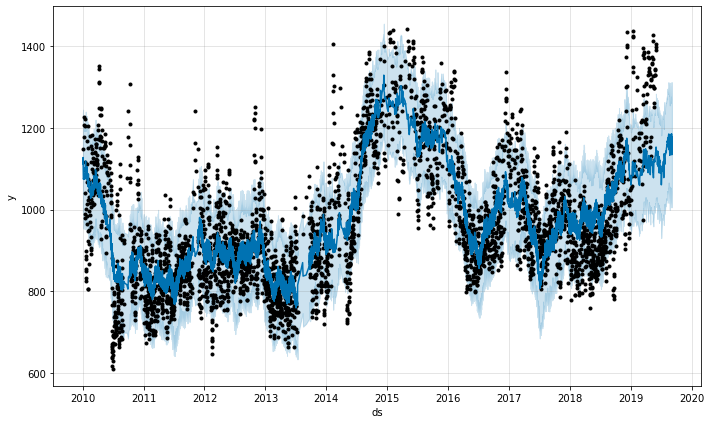

In [92]:
fig1 = m_beehive.plot(beehive_forecast)

In [93]:
# Prefit model already saved
#with open('m_beehive_model.pckl', 'wb') as fout:
#    pickle.dump(m_beehive, fout)

In [95]:
# Testing to see accuracy of predictions

testdf = beedf.loc[360186:,['utc_datetime','t_nxt_eruption']]
testdf.reset_index(inplace=True)

l = len(valdf['ds'])
traindf = beehive_forecast.iloc[(-1*l):]
traindf = traindf[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
traindf.reset_index(inplace=True)

newdf = pd.concat([traindf,testdf], axis=1)

newdf['abs_err'] = (newdf['yhat']-newdf['t_nxt_eruption']).abs()

# Mean Absolute Error
print("Mean Absolute Error for Beehive Predictions")
print(newdf['abs_err'].mean())

newdf['uncertainty'] = newdf['yhat_upper']-newdf['yhat_lower']
newdf['accr'] = 0

for i in newdf.index:
    if newdf.loc[i,'abs_err'] <= newdf.loc[i,'uncertainty']:
        newdf.loc[i,'accr'] = 1

# Accuracy of prediction
print("Accuracy of Beehive Predictions in %")
print((newdf['accr'].value_counts()[1]/len(newdf.index)) * 100)
print('Mean and Std Uncertainty')
print(newdf['uncertainty'].mean())
print(newdf['uncertainty'].std())

Mean Absolute Error for Beehive Predictions
200.426657194599
Accuracy of Beehive Predictions in %
59.210526315789465
Mean and Std Uncertainty
248.98235640104326
8.888200562164732


### Daisy

In [96]:
daisydf = maindf.loc[maindf['geyser'] == 'Daisy']
daisydf.shape

(27918, 8)

105.0     5
106.0     2
107.0     1
108.0     8
109.0     3
         ..
220.0    22
221.0    19
222.0    30
223.0    16
224.0    13
Name: t_nxt_eruption, Length: 120, dtype: int64


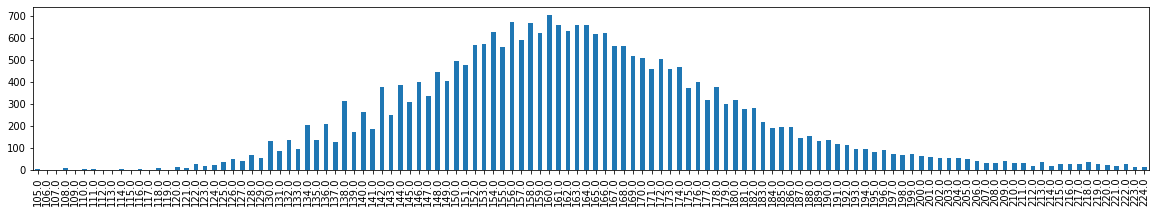

In [97]:
print(daisydf['t_nxt_eruption'].value_counts().sort_index().iloc[80:200])
daisydf['t_nxt_eruption'].value_counts().sort_index().iloc[80:200].plot.bar(figsize=(20,3))

In [98]:
print(daisydf.shape)
daisydf = daisydf.loc[(daisydf['t_nxt_eruption'] >= 105.0) & (daisydf['t_nxt_eruption'] <= 224.0)]
print(daisydf.shape)
daisydf.tail()

(27918, 8)
(25593, 8)


utc_datetime                   datetime geyser  \
376138 2019-09-05 10:09:00  2019-09-05 04:09:00-06:00  Daisy   
376149 2019-09-05 12:27:00  2019-09-05 06:27:00-06:00  Daisy   
376160 2019-09-05 14:55:00  2019-09-05 08:55:00-06:00  Daisy   
376251 2019-09-05 21:50:00  2019-09-05 15:50:00-06:00  Daisy   
376288 2019-09-06 00:03:00  2019-09-05 18:03:00-06:00  Daisy   

        eruption_time_epoch        date      time  interval_length  \
376138           1567678140  2019-09-05  04:09:00            141.0   
376149           1567686420  2019-09-05  06:27:00            138.0   
376160           1567695300  2019-09-05  08:55:00            148.0   
376251           1567720200  2019-09-05  15:50:00            279.0   
376288           1567728180  2019-09-05  18:03:00            133.0   

        t_nxt_eruption  
376138           138.0  
376149           148.0  
376160           136.0  
376251           133.0  
376288           130.0

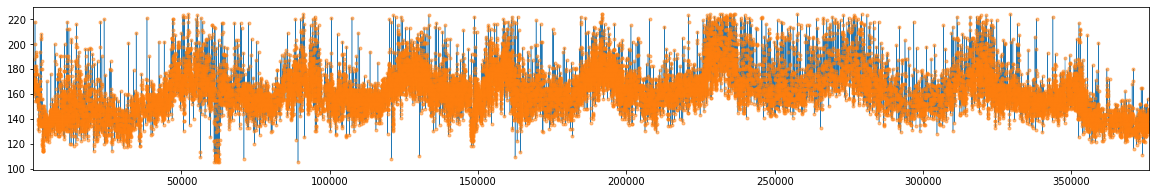

In [99]:
daisydf.t_nxt_eruption.plot(linewidth=0.5, figsize=(20, 3))
daisydf.t_nxt_eruption.plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3))

In [100]:
daisydf['smooth_interval'] = daisydf.t_nxt_eruption.rolling(5).mean()

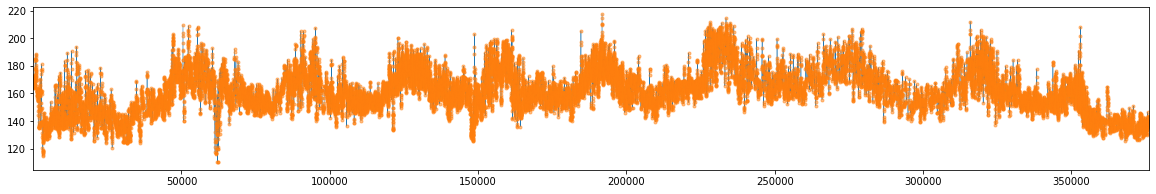

In [101]:
daisydf.smooth_interval.plot(linewidth=0.5, figsize=(20, 3))
daisydf.smooth_interval.plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3))

In [102]:
# Checking last day of May 31st 2019
print(daisydf.index[daisydf['date'] == '2019-05-31'].to_list())

[360135, 360171, 360318]


In [103]:
# creating df for prophet

cols = ['utc_datetime','smooth_interval']
ddf = daisydf.loc[:360318,cols]

valdf = daisydf.loc[360318:,cols]
valdf.drop(columns=['smooth_interval'], axis=1, inplace=True)
valdf.rename(columns = {'utc_datetime':'ds'}, inplace=True)
print(valdf.head())

ddf.rename(columns = {'utc_datetime':'ds', 'smooth_interval':'y'}, inplace=True)

ddf = ddf.reset_index()
ddf.drop(['index'], axis=1, inplace=True)

ddf

                        ds
360318 2019-06-01 05:15:00
360322 2019-06-01 07:37:00
360326 2019-06-01 10:06:00
360334 2019-06-01 12:33:00
360351 2019-06-01 14:53:00


ds      y
0     2010-01-01 07:10:00    NaN
1     2010-01-01 10:00:00    NaN
2     2010-01-01 12:56:00    NaN
3     2010-01-01 15:42:00    NaN
4     2010-01-01 18:32:00  168.4
...                   ...    ...
24767 2019-05-31 00:15:00  133.2
24768 2019-05-31 02:31:00  134.6
24769 2019-05-31 14:42:00  136.2
24770 2019-05-31 17:04:00  136.6
24771 2019-06-01 05:15:00  139.0

[24772 rows x 2 columns]

In [104]:
#m_daisy = Prophet(changepoint_prior_scale=0.25)

In [105]:
#m_daisy.fit(ddf)

In [106]:
# Opening preFit model 
with open('m_daisy_model.pckl', 'rb') as fin:
    m_daisy = pickle.load(fin)

In [107]:
l = len(valdf['ds'])
future = m_daisy.make_future_dataframe(periods=l)
future = future.iloc[:(-1*l)]
future = pd.concat([future,valdf])

In [108]:
daisy_forecast = m_daisy.predict(future)

In [109]:
print(daisy_forecast.shape)
#daisy_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
l

(25594, 22)


822

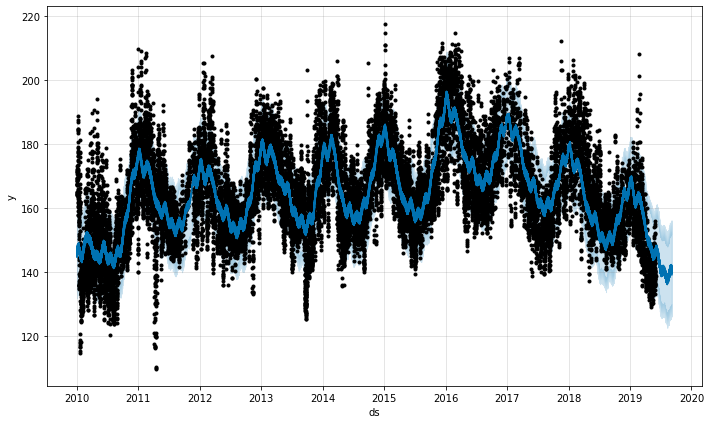

In [110]:
fig1 = m_daisy.plot(daisy_forecast)

In [111]:
# Prefit model already saved
#with open('m_daisy_model.pckl', 'wb') as fout:
#    pickle.dump(m_daisy, fout)

In [112]:
# Testing to see accuracy of predictions

testdf = daisydf.loc[360318:,['utc_datetime','t_nxt_eruption']]
testdf.reset_index(inplace=True)

l = len(valdf['ds'])
traindf = daisy_forecast.iloc[(-1*l):]
traindf = traindf[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
traindf.reset_index(inplace=True)

newdf = pd.concat([traindf,testdf], axis=1)

newdf['abs_err'] = (newdf['yhat']-newdf['t_nxt_eruption']).abs()

# Mean Absolute Error
print("Mean Absolute Error for Beehive Predictions")
print(newdf['abs_err'].mean())

newdf['uncertainty'] = newdf['yhat_upper']-newdf['yhat_lower']
newdf['accr'] = 0

for i in newdf.index:
    if newdf.loc[i,'abs_err'] <= newdf.loc[i,'uncertainty']:
        newdf.loc[i,'accr'] = 1

# Accuracy of prediction
print("Accuracy of Daisy Predictions in %")
print((newdf['accr'].value_counts()[1]/len(newdf.index)) * 100)
print('Mean and Std Uncertainty')
print(newdf['uncertainty'].mean())
print(newdf['uncertainty'].std())

Mean Absolute Error for Beehive Predictions
6.707015977453766
Accuracy of Daisy Predictions in %
98.661800486618
Mean and Std Uncertainty
24.63721763354165
0.9675122771785175


In [113]:
newdf

index                  ds        yhat  yhat_lower  yhat_upper   index  \
0    24772 2019-06-01 05:15:00  145.278007  133.251681  157.450521  360318   
1    24773 2019-06-01 07:37:00  146.124876  134.350136  157.998014  360322   
2    24774 2019-06-01 10:06:00  147.107377  135.212872  159.584687  360326   
3    24775 2019-06-01 12:33:00  147.614991  135.242649  158.981725  360334   
4    24776 2019-06-01 14:53:00  147.456908  134.924436  158.241198  360351   
..     ...                 ...         ...         ...         ...     ...   
817  25589 2019-09-05 10:09:00  141.555060  128.609052  155.511442  376138   
818  25590 2019-09-05 12:27:00  141.991893  128.825064  155.088908  376149   
819  25591 2019-09-05 14:55:00  141.778661  128.649248  154.003838  376160   
820  25592 2019-09-05 21:50:00  139.523615  127.372079  152.059880  376251   
821  25593 2019-09-06 00:03:00  139.237021  126.289987  151.953096  376288   

           utc_datetime  t_nxt_eruption    abs_err  uncertainty  accr  
0   2019-06-01 05:15:00           142.0   3.278007    24.198840     1  
1   2019-06-01 07:37:00           149.0   2.875124    23.647878     1  
2   2019-06-01 10:06:00           147.0   0.107377    24.371815     1  
3   2019-06-01 12:33:00           140.0   7.614991    23.739076     1  
4   2019-06-01 14:53:00           132.0  15.456908    23.316762     1  
..                  ...             ...        ...          ...   ...  
817 2019-09-05 10:09:00           138.0   3.555060    26.902390     1  
818 2019-09-05 12:27:00           148.0   6.008107    26.263844     1  
819 2019-09-05 14:55:00           136.0   5.778661    25.354589     1  
820 2019-09-05 21:50:00           133.0   6.523615    24.687801     1  
821 2019-09-06 00:03:00           130.0   9.237021    25.663109     1  

[822 rows x 11 columns]

### Riverside

In [114]:
riverdf = maindf.loc[maindf['geyser'] == 'Riverside']
riverdf.shape

(9289, 8)

Transforming data into t_nxt_eruption results in some data points to have extremely large values. These values represent two time-points with missing event between them. Plotting a frequency distribution of t_nxt_eruption results in long tails. These are filtered and removed to clean up the data. Currently what values to filter are decided by me based on my intuition. 

316.0    4
317.0    4
318.0    5
319.0    7
320.0    8
        ..
421.0    3
422.0    1
423.0    1
424.0    2
425.0    1
Name: t_nxt_eruption, Length: 110, dtype: int64


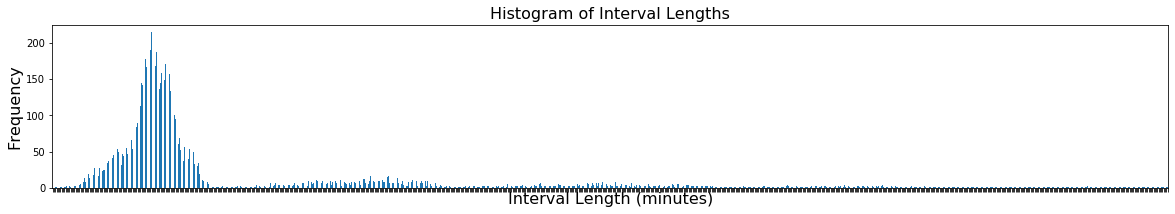

In [115]:
print(riverdf['t_nxt_eruption'].value_counts().sort_index().iloc[20:130])
ax = riverdf['t_nxt_eruption'].value_counts().sort_index().iloc[:].plot.bar(figsize=(20,3))
ax.set_xlabel("Interval Length (minutes)", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Histogram of Interval Lengths", fontsize=16)
plt.tick_params(axis='x', labelbottom=False)

Text(0.5, 1.0, 'Histogram of Interval Lengths')

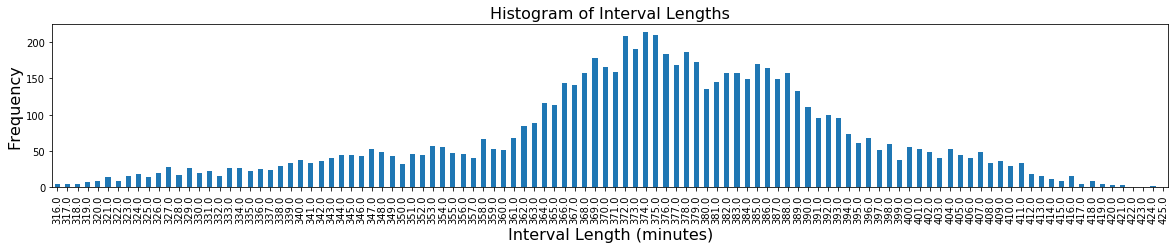

In [116]:
#print(riverdf['t_nxt_eruption'].value_counts().sort_index().iloc[20:130])
ax = riverdf['t_nxt_eruption'].value_counts().sort_index().iloc[20:130].plot.bar(figsize=(20,3))
ax.set_xlabel("Interval Length (minutes)", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Histogram of Interval Lengths", fontsize=16)
#plt.tick_params(axis='x', labelbottom=False)

In [117]:
print(riverdf.shape)
riverdf = riverdf.loc[(riverdf['t_nxt_eruption'] >= 301.0) & (riverdf['t_nxt_eruption'] <= 425.0)]
print(riverdf.shape)
riverdf.tail()

(9289, 8)
(7259, 8)


utc_datetime                   datetime     geyser  \
375212 2019-08-30 19:08:00  2019-08-30 13:08:00-06:00  Riverside   
375292 2019-08-31 12:45:00  2019-08-31 06:45:00-06:00  Riverside   
375490 2019-09-01 18:47:00  2019-09-01 12:47:00-06:00  Riverside   
375759 2019-09-03 12:12:00  2019-09-03 06:12:00-06:00  Riverside   
375942 2019-09-04 15:20:00  2019-09-04 09:20:00-06:00  Riverside   

        eruption_time_epoch        date      time  interval_length  \
375212           1567192080  2019-08-30  13:08:00            354.0   
375292           1567255500  2019-08-31  06:45:00            696.0   
375490           1567363620  2019-09-01  12:47:00           1439.0   
375759           1567512720  2019-09-03  06:12:00           1092.0   
375942           1567610400  2019-09-04  09:20:00           1262.0   

        t_nxt_eruption  
375212           361.0  
375292           363.0  
375490           367.0  
375759           366.0  
375942           353.0

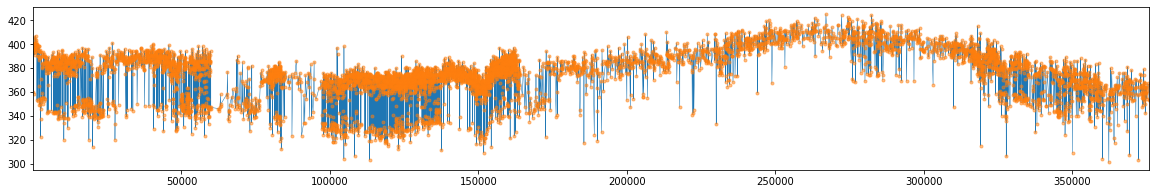

In [118]:
riverdf.t_nxt_eruption.plot(linewidth=0.5, figsize=(20, 3))
riverdf.t_nxt_eruption.plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3))
#riverdf.lag2.plot(linewidth=0.5, figsize=(20, 3))
#riverdf.lag2.plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3))

In [119]:
riverdf['smooth_interval'] = riverdf.t_nxt_eruption.rolling(5).mean()

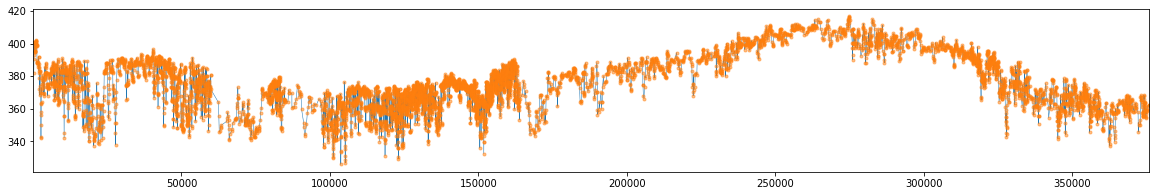

In [120]:
riverdf.smooth_interval.plot(linewidth=0.5, figsize=(20, 3))
riverdf.smooth_interval.plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3))

In [121]:
# Checking last day of May 31st 2019
print(riverdf.index[riverdf['date'] == '2019-05-31'].to_list())

[360143, 360227, 360309]


In [122]:
# creating df for prophet

cols = ['utc_datetime','smooth_interval']
rdf = riverdf.loc[:360309,cols]

valdf = riverdf.loc[360309:,cols]
valdf.drop(columns=['smooth_interval'], axis=1, inplace=True)
valdf.rename(columns = {'utc_datetime':'ds'}, inplace=True)

rdf.rename(columns = {'utc_datetime':'ds', 'smooth_interval':'y'}, inplace=True)

rdf = rdf.reset_index()
rdf.drop(['index'], axis=1, inplace=True)

rdf

ds      y
0    2010-01-01 07:35:00    NaN
1    2010-01-02 02:41:00    NaN
2    2010-01-02 09:15:00    NaN
3    2010-01-02 15:13:00    NaN
4    2010-01-02 21:51:00  382.2
...                  ...    ...
7062 2019-05-30 10:41:00  357.0
7063 2019-05-30 16:40:00  358.2
7064 2019-05-31 15:37:00  358.4
7065 2019-05-31 21:38:00  347.8
7066 2019-06-01 02:42:00  347.2

[7067 rows x 2 columns]

In [123]:
#m_river = Prophet(changepoint_prior_scale=0.25)

In [124]:
#m_river.fit(rdf)

In [125]:
# Opening preFit model 
with open('m_riverside_model.pckl', 'rb') as fin:
    m_river = pickle.load(fin)

In [126]:
l = len(valdf['ds'])
future = m_river.make_future_dataframe(periods=l)
future = future.iloc[:(-1*l)]
future = pd.concat([future,valdf])

In [127]:
river_forecast = m_river.predict(future)

In [128]:
print(river_forecast.shape)
#river_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
l

(7260, 22)


193

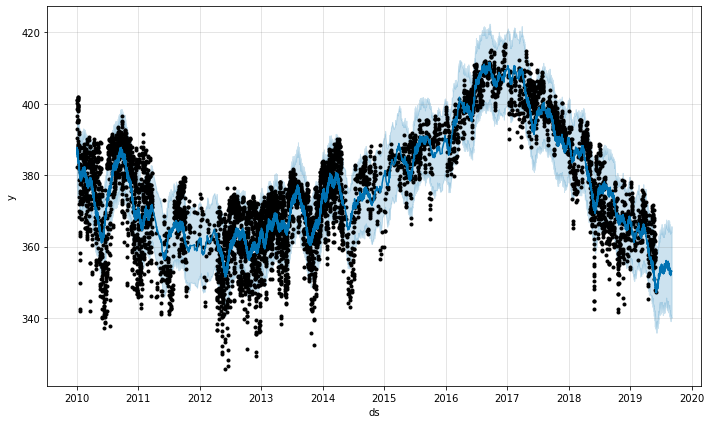

In [129]:
fig1 = m_river.plot(river_forecast)

In [130]:
# Already saved prefit model
#with open('m_riverside_model.pckl', 'wb') as fout:
#    pickle.dump(m_river, fout)

In [131]:
# Testing to see accuracy of predictions

testdf = riverdf.loc[360309:,['utc_datetime','t_nxt_eruption']]
testdf.reset_index(inplace=True)

l = len(valdf['ds'])
traindf = river_forecast.iloc[(-1*l):]
traindf = traindf[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
traindf.reset_index(inplace=True)

newdf = pd.concat([traindf,testdf], axis=1)

newdf['abs_err'] = (newdf['yhat']-newdf['t_nxt_eruption']).abs()

# Mean Absolute Error
print("Mean Absolute Error for Beehive Predictions")
print(newdf['abs_err'].mean())

newdf['uncertainty'] = newdf['yhat_upper']-newdf['yhat_lower']
newdf['accr'] = 0

for i in newdf.index:
    if newdf.loc[i,'abs_err'] <= newdf.loc[i,'uncertainty']:
        newdf.loc[i,'accr'] = 1

# Accuracy of prediction
print("Accuracy of Beehive Predictions in %")
print((newdf['accr'].value_counts()[1]/len(newdf.index)) * 100)
print('Mean and Std Uncertainty')
print(newdf['uncertainty'].mean())
print(newdf['uncertainty'].std())

Mean Absolute Error for Beehive Predictions
10.824379972426406
Accuracy of Beehive Predictions in %
92.74611398963731
Mean and Std Uncertainty
22.08569553156185
1.263683137090761


## Grand

In [132]:
granddf = maindf.loc[maindf['geyser'] == 'Grand']
granddf.shape

(11224, 8)

297.0    1
299.0    1
300.0    3
301.0    2
303.0    2
        ..
644.0    2
645.0    5
646.0    7
647.0    5
648.0    4
Name: t_nxt_eruption, Length: 350, dtype: int64


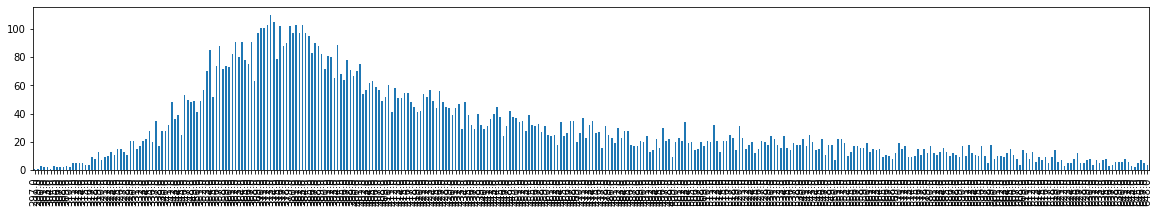

In [133]:
print(granddf['t_nxt_eruption'].value_counts().sort_index().iloc[:350])
granddf['t_nxt_eruption'].value_counts().sort_index().iloc[:350].plot.bar(figsize=(20,3))

In [134]:
print(granddf.shape)
granddf = granddf.loc[(granddf['t_nxt_eruption'] >= 297.0) & (granddf['t_nxt_eruption'] <= 648.0)]
print(granddf.shape)

(11224, 8)
(10593, 8)


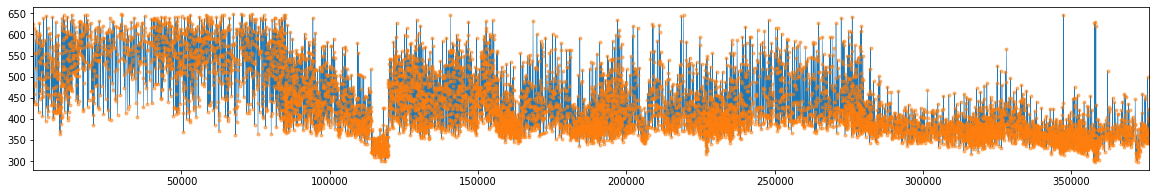

In [135]:
granddf.t_nxt_eruption.plot(linewidth=0.5, figsize=(20, 3))
granddf.t_nxt_eruption.plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3))

In [136]:
granddf['smooth_interval'] = granddf.t_nxt_eruption.rolling(5).mean()

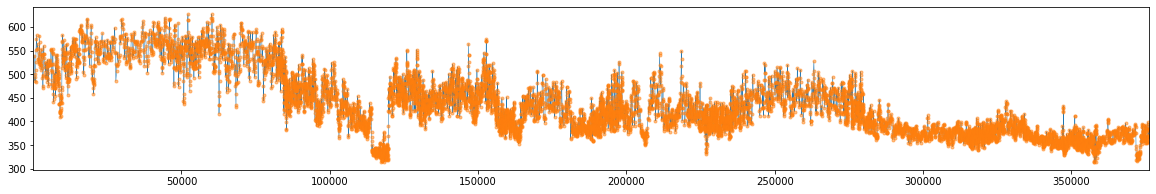

In [137]:
granddf.smooth_interval.plot(linewidth=0.5, figsize=(20, 3))
granddf.smooth_interval.plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3))

In [138]:
# Checking last day of May 31st 2019
print(granddf.index[granddf['date'] == '2019-05-31'].to_list())

[360156, 360241, 360316]


In [139]:
# creating df for prophet

cols = ['utc_datetime','smooth_interval']
gdf = granddf.loc[:360316,cols]

valdf = granddf.loc[360316:,cols]
valdf.drop(columns=['smooth_interval'], axis=1, inplace=True)
valdf.rename(columns = {'utc_datetime':'ds'}, inplace=True)
print(valdf.head())

gdf.rename(columns = {'utc_datetime':'ds', 'smooth_interval':'y'}, inplace=True)

gdf = gdf.reset_index()
gdf.drop(['index'], axis=1, inplace=True)

gdf

                        ds
360316 2019-06-01 04:18:00
360327 2019-06-01 10:18:00
360364 2019-06-01 16:13:45
360460 2019-06-01 22:36:16
360535 2019-06-02 04:52:00


ds      y
0     2010-01-01 10:21:00    NaN
1     2010-01-01 20:45:00    NaN
2     2010-01-02 06:01:00    NaN
3     2010-01-03 02:26:00    NaN
4     2010-01-04 01:01:00  539.0
...                   ...    ...
10263 2019-05-30 16:27:59  364.8
10264 2019-05-30 22:14:00  356.8
10265 2019-05-31 16:12:09  359.2
10266 2019-05-31 22:18:07  359.2
10267 2019-06-01 04:18:00  356.2

[10268 rows x 2 columns]

In [140]:
#m_grand = Prophet(changepoint_prior_scale=0.25)

In [141]:
#m_grand.fit(gdf)

In [142]:
# Opening preFit model 
with open('m_grand_model.pckl', 'rb') as fin:
    m_grand = pickle.load(fin)

In [143]:
l = len(valdf['ds'])
future = m_grand.make_future_dataframe(periods=l)
future = future.iloc[:(-1*l)]
future = pd.concat([future,valdf])

In [144]:
grand_forecast = m_grand.predict(future)

In [145]:
print(grand_forecast.shape)
#grand_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
l

(10594, 22)


326

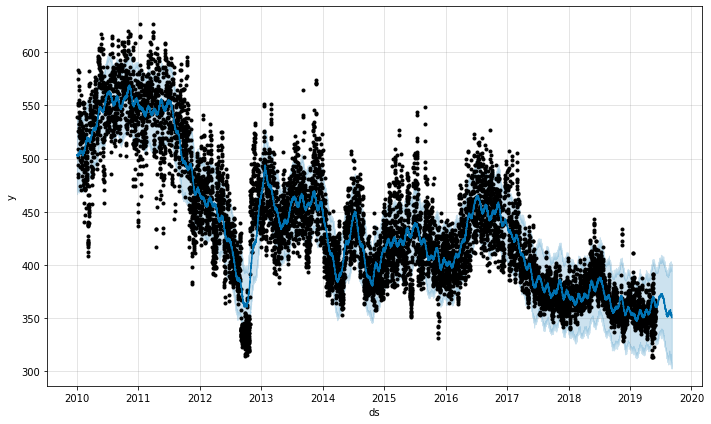

In [146]:
fig1 = m_grand.plot(grand_forecast)

In [147]:
# prefit model already saved
#with open('m_grand_model.pckl', 'wb') as fout:
#    pickle.dump(m_grand, fout)

In [148]:
# Testing to see accuracy of predictions

testdf = granddf.loc[360316:,['utc_datetime','t_nxt_eruption']]
testdf.reset_index(inplace=True)

l = len(valdf['ds'])
traindf = grand_forecast.iloc[(-1*l):]
traindf = traindf[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
traindf.reset_index(inplace=True)

newdf = pd.concat([traindf,testdf], axis=1)

newdf['abs_err'] = (newdf['yhat']-newdf['t_nxt_eruption']).abs()

# Mean Absolute Error
print("Mean Absolute Error for Beehive Predictions")
print(newdf['abs_err'].mean())

newdf['uncertainty'] = newdf['yhat_upper']-newdf['yhat_lower']
newdf['accr'] = 0

for i in newdf.index:
    if newdf.loc[i,'abs_err'] <= newdf.loc[i,'uncertainty']:
        newdf.loc[i,'accr'] = 1

# Accuracy of prediction
print("Accuracy of Beehive Predictions in %")
print((newdf['accr'].value_counts()[1]/len(newdf.index)) * 100)
print('Mean and Std Uncertainty')
print(newdf['uncertainty'].mean())
print(newdf['uncertainty'].std())

Mean Absolute Error for Beehive Predictions
19.814838606335467
Accuracy of Beehive Predictions in %
96.62576687116564
Mean and Std Uncertainty
75.3436775341033
8.036056223926742


## Castle

In [149]:
castledf = maindf.loc[maindf['geyser'] == 'Castle']
castledf.shape

(6487, 8)

746.0     2
747.0     1
748.0     3
749.0     5
750.0     4
         ..
922.0    14
923.0     3
924.0    10
925.0     4
926.0     5
Name: t_nxt_eruption, Length: 180, dtype: int64


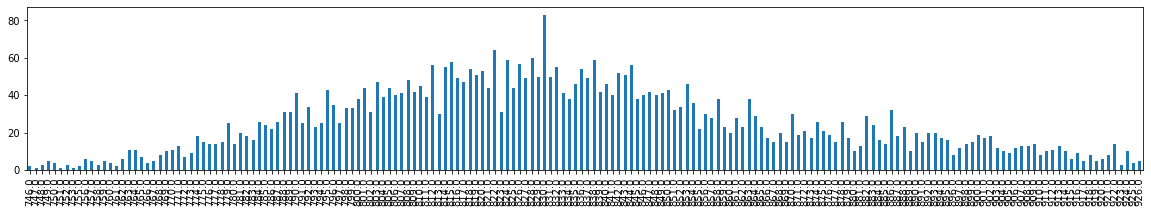

In [150]:
print(castledf['t_nxt_eruption'].value_counts().sort_index().iloc[500:680])
castledf['t_nxt_eruption'].value_counts().sort_index().iloc[500:680].plot.bar(figsize=(20,3))

In [151]:
print(castledf.shape)
castledf = castledf.loc[(castledf['t_nxt_eruption'] >= 746.0) & (castledf['t_nxt_eruption'] <= 926.0)]
print(castledf.shape)

(6487, 8)
(4556, 8)


In [152]:
castledf.set_index('utc_datetime', inplace=True)

Text(0.5, 1.0, 'Interval Lengths plotted over Time')

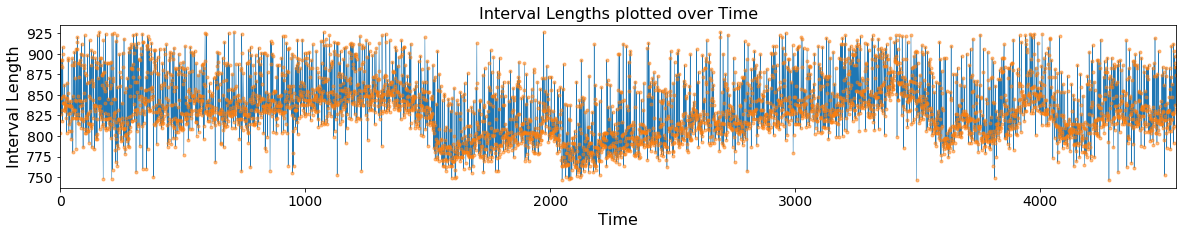

In [184]:
castledf.t_nxt_eruption.plot(linewidth=0.5, figsize=(20, 3))
ax = castledf.t_nxt_eruption.plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3), fontsize=14)
ax.set_xlabel("Time", fontsize=16)
ax.set_ylabel("Interval Length", fontsize=16)
ax.set_title("Interval Lengths plotted over Time", fontsize=16)

In [154]:
castledf['smooth_interval'] = castledf.t_nxt_eruption.rolling(5).mean()

Text(0.5, 1.0, 'Smoothed Interval Lengths plotted over Time')

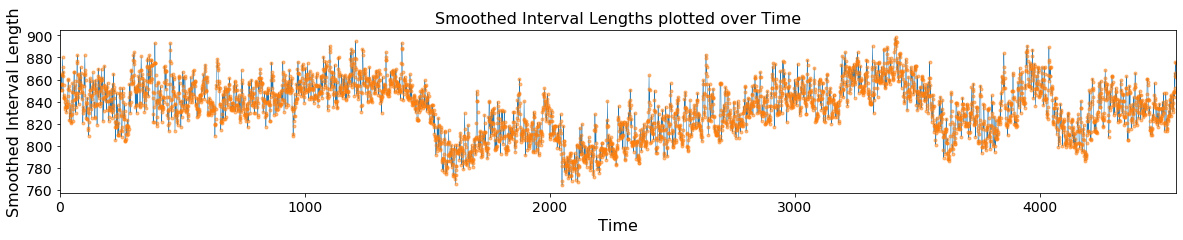

In [185]:
castledf.smooth_interval.plot(linewidth=0.5, figsize=(20, 3))
ax = castledf.smooth_interval.plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3), fontsize=14)
ax.set_xlabel("Time", fontsize=16)
ax.set_ylabel("Smoothed Interval Length", fontsize=16)
ax.set_title("Smoothed Interval Lengths plotted over Time", fontsize=16)

In [156]:
# Checking last day of May 31st 2019
castledf.reset_index(inplace = True)
print(castledf.index[castledf['date'] == '2019-05-31'].to_list())

[4423, 4424]


In [157]:
# creating df for prophet

cols = ['utc_datetime','smooth_interval']
cdf = castledf.loc[:4423,cols]

valdf = castledf.loc[4423:,cols]
valdf.drop(columns=['smooth_interval'], axis=1, inplace=True)
valdf.rename(columns = {'utc_datetime':'ds'}, inplace=True)
print(valdf.head())

cdf.rename(columns = {'utc_datetime':'ds', 'smooth_interval':'y'}, inplace=True)

cdf = cdf.reset_index()
cdf.drop(['index'], axis=1, inplace=True)

cdf.tail()

                      ds
4423 2019-05-31 06:29:00
4424 2019-06-01 00:12:00
4425 2019-06-01 14:57:00
4426 2019-06-02 08:56:00
4427 2019-06-02 23:34:00


ds      y
4419 2019-05-28 23:15:00  828.8
4420 2019-05-29 13:06:00  831.6
4421 2019-05-30 02:50:00  832.0
4422 2019-05-30 16:45:00  829.6
4423 2019-05-31 06:29:00  825.8

In [158]:
#m_castle = Prophet(changepoint_prior_scale=0.25)

In [159]:
#m_castle.fit(cdf)

In [160]:
# Opening preFit model 
with open('m_castle_model.pckl', 'rb') as fin:
    m_castle = pickle.load(fin)

In [161]:
l = len(valdf['ds'])
future = m_castle.make_future_dataframe(periods=l)
future = future.iloc[:(-1*l)]
future = pd.concat([future,valdf])

In [162]:
castle_forecast = m_castle.predict(future)

In [163]:
print(castle_forecast.shape)
#castle_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
l

(4558, 22)


133

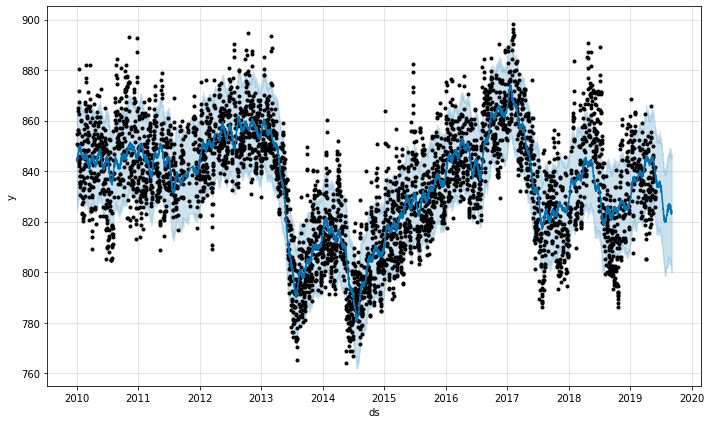

In [164]:
fig1 = m_castle.plot(castle_forecast)

In [165]:
# Already saved prefit model
#with open('m_castle_model.pckl', 'wb') as fout:
#    pickle.dump(m_castle, fout)

In [166]:
# Testing to see accuracy of predictions

testdf = castledf.loc[4423:,['utc_datetime','t_nxt_eruption']]
testdf.reset_index(inplace=True)

l = len(valdf['ds'])
traindf = castle_forecast.iloc[(-1*l):]
traindf = traindf[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
traindf.reset_index(inplace=True)

newdf = pd.concat([traindf,testdf], axis=1)

newdf['abs_err'] = (newdf['yhat']-newdf['t_nxt_eruption']).abs()

# Mean Absolute Error
print("Mean Absolute Error for Beehive Predictions")
print(newdf['abs_err'].mean())

newdf['uncertainty'] = newdf['yhat_upper']-newdf['yhat_lower']
newdf['accr'] = 0

for i in newdf.index:
    if newdf.loc[i,'abs_err'] <= newdf.loc[i,'uncertainty']:
        newdf.loc[i,'accr'] = 1

# Accuracy of prediction
print("Accuracy of Beehive Predictions in %")
print((newdf['accr'].value_counts()[1]/len(newdf.index)) * 100)
print('Mean and Std Uncertainty')
print(newdf['uncertainty'].mean())
print(newdf['uncertainty'].std())

Mean Absolute Error for Beehive Predictions
24.520475833038443
Accuracy of Beehive Predictions in %
73.68421052631578
Mean and Std Uncertainty
38.976553518368036
2.888434112043458


## Great Fountain

In [167]:
greatdf = maindf.loc[maindf['geyser'] == 'Great Fountain']
greatdf.shape

(5629, 8)

517.0    3
518.0    1
519.0    2
520.0    6
521.0    3
        ..
927.0    2
928.0    3
929.0    2
930.0    2
931.0    1
Name: t_nxt_eruption, Length: 400, dtype: int64


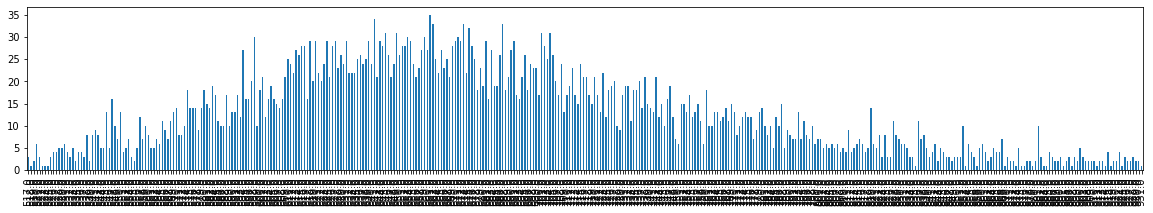

In [168]:
print(greatdf['t_nxt_eruption'].value_counts().sort_index().iloc[50:450])
greatdf['t_nxt_eruption'].value_counts().sort_index().iloc[50:450].plot.bar(figsize=(20,3))

In [169]:
print(greatdf.shape)
greatdf = greatdf.loc[(greatdf['t_nxt_eruption'] >= 517.0) & (greatdf['t_nxt_eruption'] <= 931.0)]
print(greatdf.shape)

(5629, 8)
(5079, 8)


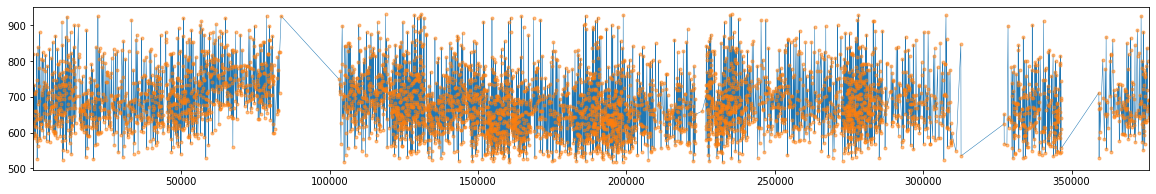

In [170]:
greatdf.t_nxt_eruption.plot(linewidth=0.5, figsize=(20, 3))
greatdf.t_nxt_eruption.plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3))

In [171]:
greatdf['smooth_interval'] = greatdf.t_nxt_eruption.rolling(5).mean()

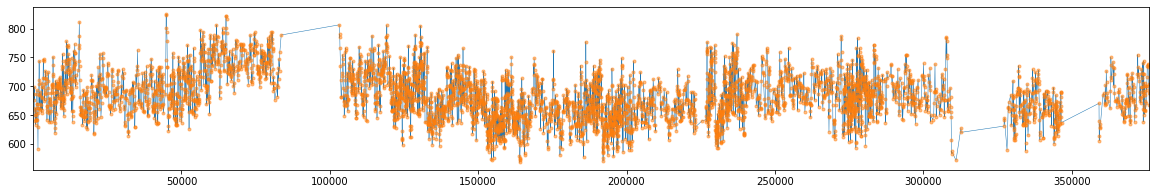

In [172]:
greatdf.smooth_interval.plot(linewidth=0.5, figsize=(20, 3))
greatdf.smooth_interval.plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3))

In [173]:
# Checking last day of May 31st 2019
print(greatdf.index[greatdf['date'] == '2019-06-02'].to_list())

[360543, 360748]


In [174]:
# creating df for prophet

cols = ['utc_datetime','smooth_interval']
gfdf = greatdf.loc[:360543,cols]

valdf = greatdf.loc[360543:,cols]
valdf.drop(columns=['smooth_interval'], axis=1, inplace=True)
valdf.rename(columns = {'utc_datetime':'ds'}, inplace=True)
print(valdf.head())

gfdf.rename(columns = {'utc_datetime':'ds', 'smooth_interval':'y'}, inplace=True)

gfdf = gfdf.reset_index()
gfdf.drop(['index'], axis=1, inplace=True)

gfdf.tail()

                        ds
360543 2019-06-02 11:15:00
360748 2019-06-03 00:39:00
361088 2019-06-04 10:29:00
361218 2019-06-04 20:10:00
361329 2019-06-05 07:01:00


ds      y
4930 2019-05-28 00:49:00  613.4
4931 2019-05-28 12:11:00  635.2
4932 2019-05-28 23:17:00  626.8
4933 2019-05-29 10:27:00  630.0
4934 2019-06-02 11:15:00  684.8

In [175]:
#m_greatfountain = Prophet(changepoint_prior_scale=0.25)

In [176]:
#m_greatfountain.fit(gfdf)

In [177]:
# Opening preFit model 
with open('m_greatfountain_model.pckl', 'rb') as fin:
    m_greatfountain = pickle.load(fin)

In [178]:
l = len(valdf['ds'])
future = m_greatfountain.make_future_dataframe(periods=l)
future = future.iloc[:(-1*l)]
future = pd.concat([future,valdf])

In [179]:
greatfountain_forecast = m_greatfountain.predict(future)

In [180]:
print(greatfountain_forecast.shape)
#greatfountain_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
l

(5080, 22)


145

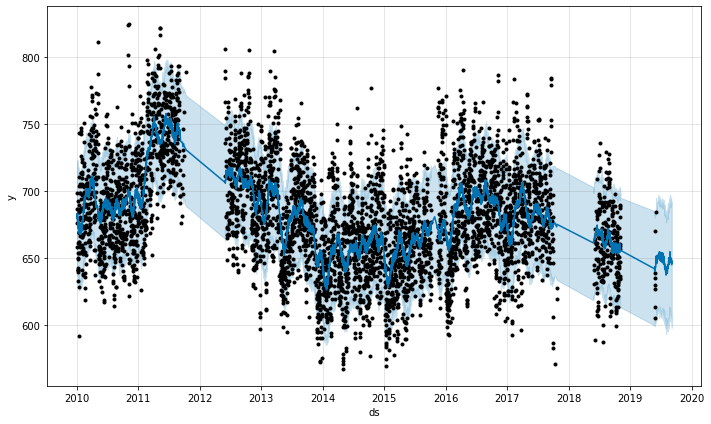

In [181]:
fig1 = m_greatfountain.plot(greatfountain_forecast)

In [182]:
# Already saved prefit model
#with open('m_greatfountain_model.pckl', 'wb') as fout:
#    pickle.dump(m_greatfountain, fout)

In [183]:
# Testing to see accuracy of predictions

testdf = greatdf.loc[360543:,['utc_datetime','t_nxt_eruption']]
testdf.reset_index(inplace=True)

l = len(valdf['ds'])
traindf = greatfountain_forecast.iloc[(-1*l):]
traindf = traindf[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
traindf.reset_index(inplace=True)

newdf = pd.concat([traindf,testdf], axis=1)

newdf['abs_err'] = (newdf['yhat']-newdf['t_nxt_eruption']).abs()

# Mean Absolute Error
print("Mean Absolute Error for Beehive Predictions")
print(newdf['abs_err'].mean())

newdf['uncertainty'] = newdf['yhat_upper']-newdf['yhat_lower']
newdf['accr'] = 0

for i in newdf.index:
    if newdf.loc[i,'abs_err'] <= newdf.loc[i,'uncertainty']:
        newdf.loc[i,'accr'] = 1

# Accuracy of prediction
print("Accuracy of Beehive Predictions in %")
print((newdf['accr'].value_counts()[1]/len(newdf.index)) * 100)
print('Mean and Std Uncertainty')
print(newdf['uncertainty'].mean())
print(newdf['uncertainty'].std())

Mean Absolute Error for Beehive Predictions
62.05421569113344
Accuracy of Beehive Predictions in %
74.48275862068967
Mean and Std Uncertainty
83.41780671645269
2.70917188275863


#### End of notebook.